In [1]:
%load_ext autoreload
%autoreload 2
from utils.dataset import Dataset
from utils.dataset_lfw import Dataset as LFW_Dataset
from utils.imageprocessing import preprocess
import model as mlib
from tqdm import tqdm
import torch
import numpy as np

In [2]:
batches = 100

In [3]:
trainset = Dataset("/gpfs/gpfs0/r.karimov/pfe/list_casia_mtcnncaffe_aligned_nooverlap.txt")

In [4]:
batch_format = {
         "size": 128,
         "num_classes": 64,
}
proc_func = lambda images: preprocess(images, True)
trainset.start_batch_queue(batch_format, proc_func=proc_func)

In [5]:
model_dict = torch.load("pfe/sota.pth.tar")

In [6]:
model = dict()
model["backbone"] = mlib.SphereNet20()
model["backbone"].load_state_dict(model_dict["backbone"])
model["uncertain"] = mlib.UncertaintyHead(512)
model["uncertain"].load_state_dict(model_dict["uncertain"])
model["criterion"] = mlib.MLSLoss(mean=False)

In [7]:
model["backbone"] = model["backbone"].cuda()
model["uncertain"] = model["uncertain"].cuda()

In [8]:
paths = LFW_Dataset("/trinity/home/r.karimov/face_uncertainty/pfe-pytorch/Probabilistic-Face-Embeddings/data/lfw_mtcnncaffe_aligned/")['abspath'] 

In [9]:
images = preprocess(paths,  False)
images = torch.from_numpy(images).to(dtype=torch.float32)    
images = images.permute(0, 3, 1, 2)

In [10]:
device = torch.device("cuda")

In [11]:
mus = []
sigs = []
cur = 0
batch_size = 256
while True:
    if cur >= images.shape[0]:
        break
    images_ = images[cur: cur + batch_size].to(device)
    cur += batch_size
    mu, sigma_sq = model["backbone"](images_)
    log_sig_sq = model["uncertain"](sigma_sq)
    mu = mu.detach().cpu()
    sigma_sq = log_sig_sq.detach().cpu()
    mus.append(mu)
    sigs.append(sigma_sq)

In [12]:
mus = torch.cat(mus, dim=0)
sigs = torch.cat(sigs, dim=0)

In [13]:
ins, inns = [], []
outs = []
inf = []
outf = []
innf = []
for ids in tqdm(range(500)):
    batch_casia = trainset.pop_batch_queue()
    
    img = torch.from_numpy(batch_casia["image"]).permute(0, 3, 1, 2)
    gty = torch.from_numpy(batch_casia["label"])
    
    img = img.to(device)
    
    feature, sig_feat = model["backbone"](img)
    log_sig_sq = model["uncertain"](sig_feat)
    
    inds = np.random.randint(0, mus.shape[0], (gty.shape[0],))
    feature_ = mus[inds].to(device)
    sigs_ = sigs[inds].to(device)
    ln = gty.shape[0]
    
    non_diag_mask = (1 - torch.eye(feature.size(0))).int()
    gty_mask = (torch.eq(gty[:, None], gty[None, :])).int()
    pos_mask = (non_diag_mask * gty_mask) > 0
    fs1 = torch.norm(feature[:,None] - feature[None,:], dim=-1)
    pk = fs1[pos_mask].mean()
    innf.append(pk.item())
    
    feature2 = torch.cat((feature, feature_), dim=0)
    log_sig_sq2 = torch.cat((log_sig_sq, sigs_), dim=0)
    
    fs = torch.norm(feature2[:,None] - feature2[None,:], dim=-1)
    
    inf.append(fs[:ln,:ln].mean().cpu().item())
    outf.append(fs[:ln,ln:].mean().cpu().item())
    
    loss_in, loss_out = model["criterion"].forward_masked(feature2, log_sig_sq2, gty, None)
    loss = model["criterion"](feature, log_sig_sq, gty)
    inns.append(loss.cpu().item())
    ins.append(loss_in.cpu().item())
    outs.append(loss_out.cpu().item())

100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

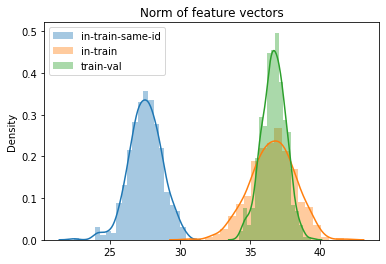

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("Norm of feature vectors")
sns.distplot(innf, label="in-train-same-id")
sns.distplot(inf, label="in-train")
sns.distplot(outf, label="train-val")
plt.legend()

/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

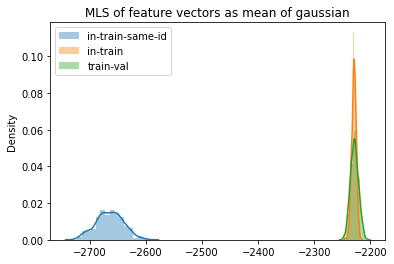

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("MLS of feature vectors as mean of gaussian")
sns.distplot(inns, label="in-train-same-id")
sns.distplot(ins, label="in-train")
sns.distplot(outs, label="train-val")
plt.legend()

/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/trinity/home/r.karimov/miniconda3/envs/py33/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


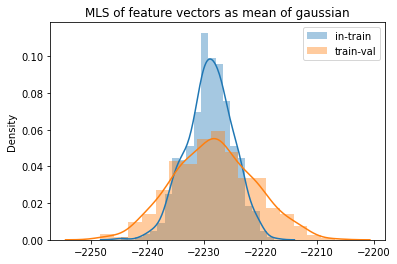

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("MLS of feature vectors as mean of gaussian")
sns.distplot(ins, label="in-train")
sns.distplot(outs, label="train-val")
plt.legend()